In [1]:
# KnetArray{Float64, 3}(undef, (2,3,4));
# a = [KnetArray{Float64,3}(undef,(10, 1, 1)),
#     KnetArray{Float64,3}(undef,(1, 784, 1)),
#     KnetArray{Float64,3}(undef,(1, 1, 100))
#     ];

In [2]:
using Knet, LinearAlgebra, AutoGrad
using AutoGrad: full
using Random
Random.seed!(0);

In [3]:
mutable struct SM3
    lr::AbstractFloat
    eps::AbstractFloat
    gclip::AbstractFloat
    dims
#     momentum::AbstractArray{AbstractFloat}
    accumulators
end

In [4]:
SM3(; lr=0.001, eps=1e-30, gclip=0.0) = SM3(lr, eps, gclip, nothing, nothing)
sm3(f,d; lr=0.001, eps=1e-30, gclip=0.0,o...) = Knet.minimize(f,d,SM3(lr, eps, gclip, nothing, nothing);o...)
sm3!(x...;o...) = for y in sm3(x...;o...); end
Knet.clone(a::SM3) = SM3(a.lr, a.eps, a.gclip, nothing, nothing)

In [5]:
for T in (Array{Float32},Array{Float64},KnetArray{Float32},KnetArray{Float64}); @eval begin
    function Knet.update!(w::$T, g, p::SM3)
        Knet.gclip!(g, p.gclip)
        g = full(g)
        if p.accumulators==nothing; 
            p.dims=size(w);
            p.accumulators=[KnetArray(zeros(Float32, _shape_for_broadcasting(p.dims, i))) for i in 1:length(p.dims)];
        end
        accumulator = _compute_past_accumulator(p.accumulators, p.dims)
        accumulator .+= g.*g
        #TODO: Add momentum tensor for scaled gradient
        axpy!(-p.lr, g./(sqrt.(accumulator .+ p.eps)), w)
        #TODO: Add accumulator updates
        p.accumulators = _accumulator_updater(p.accumulators, p.dims, accumulator)
    end
end;end

In [6]:
function _shape_for_broadcasting(dims, desired)
    rank = length(dims)
    return tuple([i==desired ? dims[i] : 1 for i in 1:rank]...)
end

_shape_for_broadcasting (generic function with 1 method)

In [7]:
function _compute_past_accumulator(accumulators, dims)
    rank = length(dims)
    accumulators_for_broadcasting = [
        reshape(accumulators[i], _shape_for_broadcasting(dims, i))
        for i in 1:rank]
    
    result = accumulators_for_broadcasting[1]
#     return result
    # Check if min is doing for number of elmns.
    for i in 1:rank
        result = min.(result, accumulators_for_broadcasting[i])
    end
    return result
    
end

_compute_past_accumulator (generic function with 1 method)

In [8]:
function _accumulator_updater(accumulators, dims, update_tensor)
    rank = length(dims)
    for i in 1:rank
        max_dims = []
#       max_dims = [i!=j ? j : for j in 1:rank]
#       TODO: Make this by array comprehension.
        for j in 1:rank
            if i!=j
                append!(max_dims, j)
            end
        end
        accumulators[i] = max.(accumulators[i], maximum(update_tensor, dims=tuple(max_dims...)))
    end
    return accumulators
end

_accumulator_updater (generic function with 1 method)

In [9]:
# a = [KnetArray{Float64,3}(undef,(10, 1, 1)),
#     KnetArray{Float64,3}(undef,(1, 784, 1)),
#     KnetArray{Float64,3}(undef,(1, 1, 100))
#     ];
# b = [10, 784, 100];
# c = rand(Float64, (10,784,100));
# _compute_past_accumulator(a, b)

In [10]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data, gpu

In [11]:
# Load data (see mnist.ipynb)
include(Knet.dir("data","mnist.jl"))  # Load data
dtrn,dtst = mnistdata();              # dtrn and dtst = [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

┌ Info: Loading MNIST...
└ @ Main /kuacc/users/ekucuk19/.julia/packages/Knet/bTNMd/data/mnist.jl:33


In [12]:
# For running experiments
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takenth(progress(sm3(model,ncycle(dtrn,100))),length(dtrn)))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [13]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [14]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [15]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [16]:
lenet =   Chain(Conv(5,5,1,20), 
                Conv(5,5,20,50), 
                Dense(800,500,pdrop=0.3), 
                Dense(500,10,identity,pdrop=0.3))
summary.(l.w for l in lenet.layers)

4-element Array{String,1}:
 "5×5×1×20 Param{KnetArray{Float32,4}}" 
 "5×5×20×50 Param{KnetArray{Float32,4}}"
 "500×800 Param{KnetArray{Float32,2}}"  
 "10×500 Param{KnetArray{Float32,2}}"   

In [17]:
sm3_results = trainresults("sm3113.jld2",lenet);
# sm3_results = Knet.load("sm3113.jld2", "results");

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 60000/60000, 04:21/04:21, 230.03i/s] 


Float32[0.079375535; 0.07033771; 0.02385; 0.0215]


In [20]:
sgd_results = trainresults("sgd113.jld2", lenet);
# sgd_results = Knet.load("sgd113.jld2", "results")

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 60000/60000, 04:14/04:14, 236.05i/s] 


Float32[0.06072745; 0.053941607; 0.018333333; 0.0173]


In [21]:
using Plots; default(fmt=:png,ls=:auto)

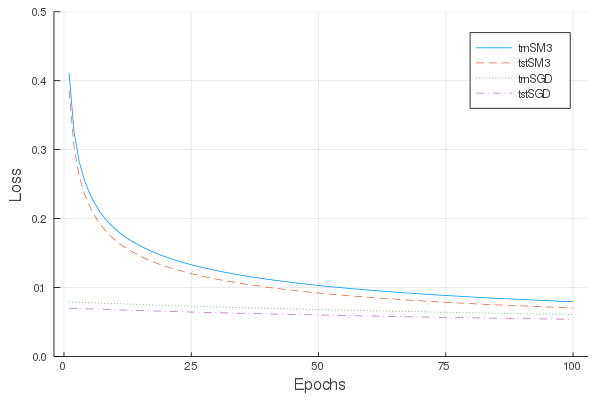

In [22]:
plot([sm3_results[1,:], sm3_results[2,:], sgd_results[1,:], sgd_results[2,:]],ylim=(0.0,0.5),
     labels=[:trnSM3 :tstSM3 :trnSGD :tstSGD],xlabel="Epochs",ylabel="Loss")